# import libraries

In [22]:
import xarray as xr
import numpy as np
import pylab as pl
import matplotlib as mpl
# mpl.use('Agg')
import sys

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import os
import pandas as pd
from matplotlib import ticker
from genutil import statistics
import scipy.stats
from scipy.stats import norm
import glob 
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from scipy.stats import ttest_rel

import utils_v1v2 as v1v2


workdir = '/home/qin4/From_Compy/home_dir/'
datadir0 = '/p/user_pub/climate_work/qin4/From_Compy/compyfs_dir/'
figdir = workdir+'/scripts/published/figure/'

# workdir = '/qfs/people/qiny108/'
# datadir0 = '/compyfs/qiny108/'
# figdir = workdir+'/scripts/figure_v1v2/' 

sys.path.append(workdir+'diag_feedback_E3SM/')
import PlotDefinedFunction as PDF

import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15

from datetime import date
today = date.today()
dd = today.strftime("%Y-%m-%d")
print(dd)

2023-10-02


# global mean RadKern 

## get data

### other CMIP models

In [3]:
Add_otherCMIPs = True 

datadir_RadKernel = datadir0+'diag_feedback_otherCMIPs/RadKernel/'

# ================ read other CMIP5&6 models ==================
if Add_otherCMIPs:
    # if only add those models with both amip and cmip runs, set do_amip_cmip = True
    do_amip_cmip = False

    phases = ['CMIP5','CMIP6']

    if do_amip_cmip:
        exp_cntl = [['piControl','amip'],['piControl','amip']]
        exp_new = [['abrupt4xCO2','amip4K'],['abrupt-4xCO2','amip-p4K']]

        suffix1 = '*_1yr-150yr.csv'
        suffix2 = '*.csv'

    else:
        exp_cntl = [['piControl','piControl'],['piControl','piControl']]
        exp_new = [['abrupt4xCO2','abrupt4xCO2'],['abrupt-4xCO2','abrupt-4xCO2']]

        suffix1 = '*_1yr-150yr.csv'
        suffix2 = '*_1yr-150yr.csv'

    prefix = 'FDBK'

    models_all,cmip5_models,cmip6_models = PDF.get_intersect(exp_cntl,exp_new,prefix,suffix1,suffix2,datadir_RadKernel+'/20220208/')
    #print('models_all',models_all,len(models_all))
    #print('cmip5_models',cmip5_models,len(cmip5_models))
    #print('cmip6_models',cmip6_models,len(cmip6_models))

    models = [cmip5_models, cmip6_models]

    df_others = pd.DataFrame()

    for iphase,phase in enumerate(phases):
        if phase == 'CMIP5':
            suffix = '_Latest-Oct18_1yr-27yr'
        else:
            suffix = '_Latest-Oct18_1yr-36yr'

        for imodel,model in enumerate(models[iphase]):

            if do_amip_cmip:
                if model == 'CanESM2':
                    model_amip = 'CanAM4'
                elif model == 'HadGEM2-ES':
                    model_amip = 'HadGEM2-A'
                else:
                    model_amip = model

                df = pd.read_csv(datadir_RadKernel+'FDBK_'+phase+'_'+exp_new[iphase][1]+'_'+model_amip+suffix+'.csv',index_col=0)
            else:
                ff = glob.glob(datadir_RadKernel+'/20220208/FDBK_'+phase+'_'+exp_new[iphase][1]+'_'+model+'_*_1yr-150yr.csv')
                if len(ff) == 0:
                    print('We dont find data for ',model,'please check!!!')
                else:
                    # print(ff)
                    df = pd.read_csv(ff[0],index_col=0)

            df2 = df.iloc[:,0]
            df_others[model] = df2
            
print(df_others)

                 ACCESS1-0  ACCESS1-3  bcc-csm1-1-m  bcc-csm1-1   BNU-ESM  \
T                -3.643694  -3.666470     -3.604957   -3.413962 -3.339827   
Planck           -3.269118  -3.311189     -3.311515   -3.249055 -3.254194   
LR               -0.403935  -0.385682     -0.292276   -0.164773 -0.085422   
WV                1.771125   1.743599      1.628795    1.476834  1.562282   
ALB               0.473552   0.460379      0.458916    0.520494  0.723674   
dLW_adj           0.235852   0.226577      0.198301    0.158708  0.163259   
dSW_adj           0.066462   0.084837      0.102301    0.131566  0.207129   
dnet_adj          0.303608   0.311419      0.300830    0.290458  0.370535   
SWCRE             0.017110   0.392821     -0.126768   -0.273338 -0.441860   
LWCRE             0.090925  -0.125254      0.159097    0.214925  0.165147   
netCRE            0.108036   0.267567      0.032329   -0.058412 -0.276713   
SWCRE_adj         0.081796   0.477682     -0.025821   -0.142870 -0.235468   

### get E3SM data

In [7]:
cases_here = ['v1_coupled','v2_coupled','v1','v2',
              # 'v1.SSTv1','v2.SSTv2',
             ]

datadir_v1 = datadir0+'diag_feedback_otherCMIPs/E3SMv1_data/'
datadir_v2 = workdir+'diag_feedback_E3SM/data/'

df_all = pd.DataFrame()

# =================== E3SM ============================
for icase,case in enumerate(cases_here):
    if case == 'v1_coupled':
        # read v1-coupled 
        df_coupled = pd.read_csv(datadir_v1+'FDBK_CMIP6_abrupt-4xCO2_E3SM-1-0_r1i1p1f1_1yr-150yr.csv',index_col=0)
        df_all['v1_coupled'] = df_coupled.iloc[:,0]
    elif case == 'v1_amip4K':
        # read v1-amip
        df_amip = pd.read_csv(datadir_v1+'FDBK_CMIP6_amip-p4K_E3SM-1-0_r2i1p1f1_1yr-36yr.csv',index_col=0)
        df_all['v1_amip4K'] = df_amip.iloc[:,0]
    elif case == 'v1_future4K':
        # read v1-amip
        df_amip = pd.read_csv(datadir_v1+'FDBK_CMIP6_amip-future4K_E3SM-1-0_r2i1p1f1_1yr-36yr.csv',index_col=0)
        df_all['v1_future4K'] = df_amip.iloc[:,0]
    elif case == 'amip-4xCO2':
        continue
    else:    
        df1 = pd.read_csv(datadir_v2+'FDBK_CMIP6_'+case+'.csv',index_col=0)
        if 'a4SST' in case or 'amip-p4K-CESM2' in case:
            MODEL = 'CESM2'
        else:
            MODEL = 'E3SM-1-0'

        df2 = df1.loc[:,MODEL]

        df_all[case] = df2
        
# print(df_all.loc['SWCRE_adj',:])
# print(df_all.loc['LWCRE_adj',:])
# print(df_all.loc['netCRE_adj',:])
print(df_all.round(2))

                 v1_coupled  v2_coupled    v1    v2
T                     -3.88       -3.59 -4.11 -4.08
Planck                -3.36       -3.29 -3.32 -3.32
LR                    -0.53       -0.30 -0.79 -0.76
WV                     1.86        1.64  1.98  1.98
ALB                    0.34        0.45  0.28  0.26
dLW_adj                0.30        0.22  0.41  0.39
dSW_adj               -0.02        0.04 -0.03 -0.03
dnet_adj               0.28        0.26  0.38  0.35
SWCRE                  0.78        0.58  0.34  0.34
LWCRE                 -0.12       -0.12 -0.07 -0.23
netCRE                 0.65        0.46  0.27  0.11
SWCRE_adj              0.76        0.63  0.31  0.31
LWCRE_adj              0.17        0.09  0.34  0.16
netCRE_adj             0.93        0.72  0.65  0.46
LW_resd                0.21        0.13 -0.04 -0.08
SW_resd               -0.09       -0.10 -0.09 -0.07
net_resd               0.12        0.03 -0.13 -0.15
T_clr                 -3.97       -3.72 -4.16 -4.13
Planck_clr  

### get ERF for other CMIP models

In [5]:
Add_otherCMIPs = True 

datadir_RadFeedback = datadir0+'diag_feedback_otherCMIPs/RadFeedback/'

# ================ read other CMIP5&6 models ==================
if Add_otherCMIPs:
    # if only add those models with both amip and cmip runs, set do_amip_cmip = True
    do_amip_cmip = False

    phases = ['CMIP5','CMIP6']

    if do_amip_cmip:
        exp_cntl = [['piControl','amip'],['piControl','amip']]
        exp_new = [['abrupt4xCO2','amip4K'],['abrupt-4xCO2','amip-p4K']]

        suffix1 = '*_1yr-150yr.csv'
        suffix2 = '*.csv'

    else:
        exp_cntl = [['piControl','piControl'],['piControl','piControl']]
        exp_new = [['abrupt4xCO2','abrupt4xCO2'],['abrupt-4xCO2','abrupt-4xCO2']]

        suffix1 = '*_1yr-150yr.csv'
        suffix2 = '*_1yr-150yr.csv'

    prefix = 'FDBK'

    models_all,cmip5_models,cmip6_models = PDF.get_intersect(exp_cntl,exp_new,prefix,suffix1,suffix2,datadir_RadKernel+'/20220208/')
    # print('models_all',models_all,len(models_all))
    #print('cmip5_models',cmip5_models,len(cmip5_models))
    #print('cmip6_models',cmip6_models,len(cmip6_models))

    models = [cmip5_models, cmip6_models]

    df_ERF_others = pd.DataFrame()

    for iphase,phase in enumerate(phases):
        if phase == 'CMIP5':
            suffix = '_Latest-Oct18_1yr-27yr'
        else:
            suffix = '_Latest-Oct18_1yr-36yr'

        for imodel,model in enumerate(models[iphase]):

            if do_amip_cmip:
                if model == 'CanESM2':
                    model_amip = 'CanAM4'
                elif model == 'HadGEM2-ES':
                    model_amip = 'HadGEM2-A'
                else:
                    model_amip = model
                
                df = pd.read_csv(datadir_RadFeedback+'global_mean_features_'+phase+'_'+exp_new[iphase][1]+'_'+model_amip+'.csv',index_col=0)
            else:
                ff = glob.glob(datadir_RadFeedback+'global_mean_features_'+phase+'_'+exp_new[iphase][1]+'_'+model+'*.csv')
                # print(datadir_RadFeedback+'global_mean_features_'+phase+'_'+exp_new[iphase][1]+'_'+model+'.csv')
                
                if len(ff) == 0:
                    print('We dont find data for ',model,'please check!!!')
                    value = np.nan
                else:
                    for fftmp in ff:
                        if 'yr' not in fftmp: 
                            ffuse = fftmp 
                            break 
                    # print(ffuse)
                    df = pd.read_csv(ffuse,index_col=0)

                    df.index = df.iloc[:,0]
                    
                    value = df.loc['FTOA','forcing']
                    # print(model,value)
                    if model == 'FGOALS-s2':
                        value = np.nan
                
            df_ERF_others.loc['ERF',model] = value
            
print(df_ERF_others)
print(df_ERF_others.loc[:,'CNRM-CM5-2'])


We dont find data for  CNRM-CM5-2 please check!!!
We dont find data for  IPSL-CM5A-MR please check!!!
We dont find data for  CMCC-ESM2 please check!!!
We dont find data for  EC-Earth3-AerChem please check!!!
We dont find data for  FGOALS-g3 please check!!!
We dont find data for  HadGEM3-GC31-LL please check!!!
We dont find data for  HadGEM3-GC31-MM please check!!!
We dont find data for  IPSL-CM5A2-INCA please check!!!
We dont find data for  NESM3 please check!!!
     ACCESS1-0  ACCESS1-3  bcc-csm1-1-m  bcc-csm1-1  BNU-ESM  CanESM2  CCSM4  \
ERF      5.774      5.677         6.851       6.352    7.422    7.532  6.855   

     CNRM-CM5-2  CNRM-CM5  CSIRO-Mk3-6-0  ...  MPI-ESM-1-2-HAM  MPI-ESM1-2-HR  \
ERF         NaN     7.268          5.105  ...            8.262          7.137   

     MPI-ESM1-2-LR  MRI-ESM2-0  NESM3  NorESM2-LM  NorESM2-MM  SAM0-UNICON  \
ERF          8.342       6.807    NaN       6.627       7.008        7.522   

     TaiESM1  UKESM1-0-LL  
ERF    7.563        7.17

### get ERF for E3SM

In [8]:
cases_here = ['v1_coupled','v2_coupled','v1','v2',
              # 'v1.SSTv1','v2.SSTv2'
             ]

datadir_v1 = datadir0+'diag_feedback_otherCMIPs/E3SMv1_data/'
datadir_v2 = workdir+'diag_feedback_E3SM/data/'

df_ERF_all = pd.DataFrame()

# =================== E3SM ============================
for icase,case in enumerate(cases_here):
    if case == 'v1_coupled':
        # read v1-coupled 
        df_coupled = pd.read_csv(datadir_v1+'global_mean_features_CMIP6_abrupt-4xCO2_E3SM-1-0_r1i1p1f1.csv',index_col=0)
        print(df_coupled)
        df_ERF_all.loc['ERF','v1_coupled'] = df_coupled.iloc[6,3]
    elif case == 'v2_coupled':    
        df1 = pd.read_csv(datadir_v2+'FDBK_forcing_CMIP6_'+case+'.csv',index_col=0)
        MODEL = 'E3SM-1-0'
        value = df1.loc['net_cld_dir',MODEL]
        df_ERF_all.loc['ERF',case] = value
    else:
        value = np.nan
        df_ERF_all.loc['ERF',case] = value
        
print(df_ERF_all)

   varname  anomaly  anomaly_perK  forcing
0      tas    7.271         1.000    0.000
0    SWCRE    4.028         0.776   -1.607
0    LWCRE   -2.014        -0.124   -1.117
0   netCRE    2.013         0.652   -2.724
0    SWCLR    4.761         0.487    1.222
0    LWCLR   -4.682        -1.768    8.173
0     FTOA    2.092        -0.629    6.671
0     FSNT    8.789         1.263   -0.385
0     FLNT   -6.697        -1.892    7.056
0  FTOACLR    0.079        -1.281    9.395
0  FSNTCLR    4.761         0.487    1.222
0  FLNTCLR   -4.682        -1.768    8.173
     v1_coupled  v2_coupled  v1  v2
ERF       6.671    5.892591 NaN NaN


## Figure 1

In [9]:
save2table = False

# =============== refine data for plotting ===================================
drop_index = ['T','dLW_adj','dSW_adj','dnet_adj','LW_resd','SW_resd',\
#'net_resd',\
'Planck','LR','WV',\
'T_clr','Planck_clr','LR_clr','WV_clr','ALB_clr','WV_clr_SW','WV_clr_LW','WV_SW','WV_LW',\
'SWCRE','LWCRE','netCRE','Planck_clr_fxRH','LR_clr_fxRH','RH_clr','LW_clr_sum','SW_clr_sum',\
'net_clr_sum','LW_clr_dir','SW_clr_dir','net_clr_dir','LW_cld_sum','SW_cld_sum',\
'net_cld_sum',\
'LW_cld_dir','SW_cld_dir',\
'SWCRE_adj','LWCRE_adj',\
#'net_cld_dir',\
'LW_clr_resd','SW_clr_resd','net_clr_resd']

df_plot = df_all.drop(index=drop_index)
x = np.arange(1,len(df_plot.index)+1,1)
# print(df_plot.index)

if Add_otherCMIPs:
    df_others_plot = df_others.drop(index=drop_index)

print(df_plot)

# redefine column orders 
# indexA = ['Planck','LR','WV','ALB','netCRE_adj','SWCRE_adj','LWCRE_adj','net_cld_dir','net_resd','Planck_fxRH','LR_fxRH','RH']
# xticks = ['Planck','LR','WV','Albedo','Cloud','Cloud$_{sw}$','Cloud$_{lw}$','Total','Residual','Planck\n[fixed RH]','LR\n[fixed RH]','RH']

indexA = ['Planck_fxRH','LR_fxRH','RH','ALB','netCRE_adj','net_cld_dir','net_resd']
xticks = ['Planck','LR','RH','Albedo','Cloud','Total','Residual']

# =============== output the dataframe df_plot as a table ====================
if save2table: 
    df_plot_flip = df_plot.transpose()
    df_plot_flip = df_plot_flip.reindex(columns=indexA)
    df_plot_flip.columns = xticks
    df_plot_flip.index = [item.split('.')[-1] for item in df_plot_flip.index]
    print(df_plot_flip.round(2))
    df_plot_flip_out = df_plot_flip.round(2)
    df_out = df_plot_flip_out.applymap("{:.2f}".format)
    print(df_out)
    df_out.to_csv(figdir+'climate_feedback_table_'+cases_here[-1]+'_ERF.csv')
    

             v1_coupled  v2_coupled        v1        v2
ALB            0.339195    0.450360  0.280474  0.255232
netCRE_adj     0.933202    0.721061  0.648290  0.461460
net_resd       0.120282    0.032551 -0.126387 -0.151488
Planck_fxRH   -1.936160   -1.935818 -1.906990 -1.900004
LR_fxRH       -0.106735   -0.000710 -0.209501 -0.183978
RH             0.013778   -0.006216 -0.022194 -0.013428
net_cld_dir   -0.630713   -0.739227 -1.336310 -1.532206


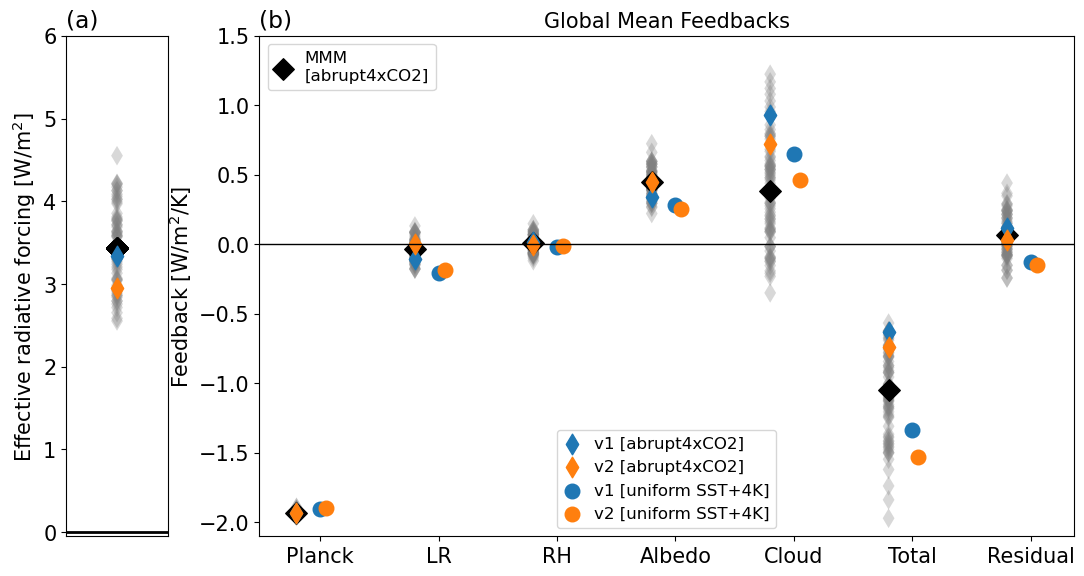

In [11]:
from matplotlib.gridspec import GridSpec

# ================ start plotting ==========================
# fig = plt.figure(figsize=(16,9))
fig = plt.figure(figsize=(13,6.5))

gs = GridSpec(1, 2, width_ratios=[1, 8])
ax = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[0])

s1 = 110
s2 = 100 
# colors = PDF.get_color('tab10',len(cases_here))
colors = ['tab:blue','tab:orange','tab:blue','tab:orange','tab:blue','tab:orange'] 
a1 = 1
fh = 15
fh1 = 13

# ============= plot ERF ===========================
for icol,column in enumerate(df_ERF_others.columns):
    ax2.scatter(1,df_ERF_others.loc['ERF',column].tolist()/2,s=s2,edgecolor='none',facecolor='grey',alpha=0.3,marker='d')
    
    # ensemble mean
    ax2.scatter(1, df_ERF_others.loc['ERF',:].mean()/2,s=s2+20,edgecolor='black',facecolor='black',marker='D')

#====== E3SM only 
for icol,column in enumerate(df_ERF_all.columns):
    ax2.scatter(1,df_ERF_all.loc['ERF',column].tolist()/2,s=s1,alpha=a1,label='_nolegend_',color=colors[icol],marker='d')

ax2.set_ylabel('Effective radiative forcing [W/m$^2$]',fontsize=fh)
ax2.axes.xaxis.set_visible(False)
ax2.set_ylim((-0.05,6))
ax2.axhline(y=0,ls='-',color='black',lw=2)
ax2.set_title('(a)',loc='left')

ax.set_title('(b)',loc='left')
         
# ============= plot feedbacks =====================

for idx,index in enumerate(indexA):
    # =========== other CMIP models
    if Add_otherCMIPs:
        for icol,column in enumerate(df_others_plot.columns):
            
            ax.scatter(x[idx]-0.2, df_others_plot.loc[index,column].tolist(),s=s2,edgecolor='none',facecolor='grey',alpha=0.3,marker='d')

        # ensemble mean
        L2 = ax.scatter(x[idx]-0.2, df_others_plot.loc[index,:].mean(),s=s2+20,edgecolor='black',facecolor='black',marker='D')

    # =========== E3SM only 
    for icol,column in enumerate(df_plot.columns):
        if column == 'v1_coupled' or column == 'v2_coupled':
            label = column.split('_')[0]+" [abrupt4xCO2]"
            if 'v2.NARRM.coupled' in df_plot.columns and column == 'v2_coupled':
                label = 'v2.LR'
            L1 = ax.scatter(x[idx]-0.2,df_plot.loc[index,column].tolist(),s=s1,alpha=a1,label=label,color=colors[icol],marker='d')
        elif column == 'v1_amip4K':
            ax.scatter(x[idx],df_plot.loc[index,column].tolist(),s=s1,alpha=a1,label=column,color=colors[icol],marker='x')
        elif column == 'v1_future4K':
            ax.scatter(x[idx],df_plot.loc[index,column].tolist(),s=s1,alpha=a1,label=column,color=colors[icol],marker='x')
        elif 'SST' in column:
            label = column.split('.')[0]+' [non-uniform SST+4K]'
            ax.scatter(x[idx]+icol/20.-len(df_plot.columns)/2.*1/20.,df_plot.loc[index,column].tolist(),s=s1,alpha=a1,label=label,
                       color=colors[icol],marker='+')
        else:
            if 'gwenergy' in column:
                label = 'All'
            elif column == 'v2.NARRM.coupled':
                label = 'v2.NARRM'
            elif 'SST' in column:
                label = column
            else:
                label = column.split('.')[-1]

            if column == 'v1' or column == 'v2': 
                label = column +" [uniform SST+4K]" 
                
            ax.scatter(x[idx]+icol/20.-len(df_plot.columns)/2.*1/20.,df_plot.loc[index,column].tolist(),s=s1,alpha=a1,label=label,
                       color=colors[icol])


    ax.tick_params(labelsize=fh)
    ax.set_ylabel('Feedback [W/m$^2$/K]',fontsize=fh)
    if idx == 0:
        if Add_otherCMIPs:
            if do_amip_cmip:
                label = 'amip4K'
            else:
                label = 'MMM\n[abrupt4xCO2]'

            legend1 = ax.legend([L2],[label],fontsize=12,loc='upper left')
            # ax.legend(fontsize=12,loc='upper right')
            ax.legend(fontsize=12,loc='lower center')
            ax.add_artist(legend1) 
        else:
            ax.legend(fontsize=12)

#ax.grid(which='major', linestyle=':', linewidth='1.0', color='grey')
ax.axhline(y=0,ls='-',color='black',lw=1)
degrees = 0

ax.set_xticks(x,xticks,rotation=degrees)
ax.set_title('Global Mean Feedbacks',fontsize=fh)

# # Add reference line between Cloud and Cloud_sw
# ax.axvline(x=5.5,ls='--',color='grey')
# # between Cloud_lw and Total 
# ax.axvline(x=7.5,ls='--',color='grey')
# # between Total and Residual
# ax.axvline(x=8.5,ls='--',color='grey')
# # between Residual and Planck_fxRH
# ax.axvline(x=9.5,ls='--',color='grey')

# ax.set_ylim((-3.5,2.5))
ax.set_ylim((-2.1,1.5))

fig.savefig(figdir+'ScatterPlot-RadKernel-NetFeedback_'+cases_here[-1]+'_'+dd+'.png',bbox_inches='tight',dpi=300)
fig.savefig(figdir+'ScatterPlot-RadKernel-NetFeedback_'+cases_here[-1]+'_'+dd+'.pdf',bbox_inches='tight') 
# plt.close(fig)


## Figure S1

### re-get E3SM data

In [12]:
cases_here = ['v1_coupled','v2_coupled','v1','v2',
              'v1.SSTv1','v2.SSTv2',
             ]

datadir_v1 = datadir0+'diag_feedback_otherCMIPs/E3SMv1_data/'
datadir_v2 = workdir+'diag_feedback_E3SM/data/'

df_all = pd.DataFrame()

# =================== E3SM ============================
for icase,case in enumerate(cases_here):
    if case == 'v1_coupled':
        # read v1-coupled 
        df_coupled = pd.read_csv(datadir_v1+'FDBK_CMIP6_abrupt-4xCO2_E3SM-1-0_r1i1p1f1_1yr-150yr.csv',index_col=0)
        df_all['v1_coupled'] = df_coupled.iloc[:,0]
    elif case == 'v1_amip4K':
        # read v1-amip
        df_amip = pd.read_csv(datadir_v1+'FDBK_CMIP6_amip-p4K_E3SM-1-0_r2i1p1f1_1yr-36yr.csv',index_col=0)
        df_all['v1_amip4K'] = df_amip.iloc[:,0]
    elif case == 'v1_future4K':
        # read v1-amip
        df_amip = pd.read_csv(datadir_v1+'FDBK_CMIP6_amip-future4K_E3SM-1-0_r2i1p1f1_1yr-36yr.csv',index_col=0)
        df_all['v1_future4K'] = df_amip.iloc[:,0]
    elif case == 'amip-4xCO2':
        continue
    else:    
        df1 = pd.read_csv(datadir_v2+'FDBK_CMIP6_'+case+'.csv',index_col=0)
        if 'a4SST' in case or 'amip-p4K-CESM2' in case:
            MODEL = 'CESM2'
        else:
            MODEL = 'E3SM-1-0'

        df2 = df1.loc[:,MODEL]

        df_all[case] = df2
        
# print(df_all.loc['SWCRE_adj',:])
# print(df_all.loc['LWCRE_adj',:])
# print(df_all.loc['netCRE_adj',:])
print(df_all.round(2))

                 v1_coupled  v2_coupled    v1    v2  v1.SSTv1  v2.SSTv2
T                     -3.88       -3.59 -4.11 -4.08     -3.98     -3.86
Planck                -3.36       -3.29 -3.32 -3.32     -3.33     -3.31
LR                    -0.53       -0.30 -0.79 -0.76     -0.65     -0.54
WV                     1.86        1.64  1.98  1.98      1.96      1.88
ALB                    0.34        0.45  0.28  0.26      0.23      0.23
dLW_adj                0.30        0.22  0.41  0.39      0.35      0.30
dSW_adj               -0.02        0.04 -0.03 -0.03     -0.04     -0.04
dnet_adj               0.28        0.26  0.38  0.35      0.31      0.26
SWCRE                  0.78        0.58  0.34  0.34      0.74      0.81
LWCRE                 -0.12       -0.12 -0.07 -0.23     -0.11     -0.23
netCRE                 0.65        0.46  0.27  0.11      0.63      0.59
SWCRE_adj              0.76        0.63  0.31  0.31      0.70      0.78
LWCRE_adj              0.17        0.09  0.34  0.16      0.25   

### re-get ERF for E3SM

In [13]:
cases_here = ['v1_coupled','v2_coupled','v1','v2',
              'v1.SSTv1','v2.SSTv2'
             ]

datadir_v1 = datadir0+'diag_feedback_otherCMIPs/E3SMv1_data/'
datadir_v2 = workdir+'diag_feedback_E3SM/data/'

df_ERF_all = pd.DataFrame()

# =================== E3SM ============================
for icase,case in enumerate(cases_here):
    if case == 'v1_coupled':
        # read v1-coupled 
        df_coupled = pd.read_csv(datadir_v1+'global_mean_features_CMIP6_abrupt-4xCO2_E3SM-1-0_r1i1p1f1.csv',index_col=0)
        print(df_coupled)
        df_ERF_all.loc['ERF','v1_coupled'] = df_coupled.iloc[6,3]
    elif case == 'v2_coupled':    
        df1 = pd.read_csv(datadir_v2+'FDBK_forcing_CMIP6_'+case+'.csv',index_col=0)
        MODEL = 'E3SM-1-0'
        value = df1.loc['net_cld_dir',MODEL]
        df_ERF_all.loc['ERF',case] = value
    else:
        value = np.nan
        df_ERF_all.loc['ERF',case] = value
        
print(df_ERF_all)

   varname  anomaly  anomaly_perK  forcing
0      tas    7.271         1.000    0.000
0    SWCRE    4.028         0.776   -1.607
0    LWCRE   -2.014        -0.124   -1.117
0   netCRE    2.013         0.652   -2.724
0    SWCLR    4.761         0.487    1.222
0    LWCLR   -4.682        -1.768    8.173
0     FTOA    2.092        -0.629    6.671
0     FSNT    8.789         1.263   -0.385
0     FLNT   -6.697        -1.892    7.056
0  FTOACLR    0.079        -1.281    9.395
0  FSNTCLR    4.761         0.487    1.222
0  FLNTCLR   -4.682        -1.768    8.173
     v1_coupled  v2_coupled  v1  v2  v1.SSTv1  v2.SSTv2
ERF       6.671    5.892591 NaN NaN       NaN       NaN


### plot

In [14]:
save2table = False

# =============== refine data for plotting ===================================
drop_index = ['T','dLW_adj','dSW_adj','dnet_adj','LW_resd','SW_resd',\
#'net_resd',\
'Planck','LR','WV',\
'T_clr','Planck_clr','LR_clr','WV_clr','ALB_clr','WV_clr_SW','WV_clr_LW','WV_SW','WV_LW',\
'SWCRE','LWCRE','netCRE','Planck_clr_fxRH','LR_clr_fxRH','RH_clr','LW_clr_sum','SW_clr_sum',\
'net_clr_sum','LW_clr_dir','SW_clr_dir','net_clr_dir','LW_cld_sum','SW_cld_sum',\
'net_cld_sum',\
'LW_cld_dir','SW_cld_dir',\
'SWCRE_adj','LWCRE_adj',\
#'net_cld_dir',\
'LW_clr_resd','SW_clr_resd','net_clr_resd']

df_plot = df_all.drop(index=drop_index)
x = np.arange(1,len(df_plot.index)+1,1)
# print(df_plot.index)

if Add_otherCMIPs:
    df_others_plot = df_others.drop(index=drop_index)

print(df_plot)

# redefine column orders 
# indexA = ['Planck','LR','WV','ALB','netCRE_adj','SWCRE_adj','LWCRE_adj','net_cld_dir','net_resd','Planck_fxRH','LR_fxRH','RH']
# xticks = ['Planck','LR','WV','Albedo','Cloud','Cloud$_{sw}$','Cloud$_{lw}$','Total','Residual','Planck\n[fixed RH]','LR\n[fixed RH]','RH']

indexA = ['Planck_fxRH','LR_fxRH','RH','ALB','netCRE_adj','net_cld_dir','net_resd']
xticks = ['Planck','LR','RH','Albedo','Cloud','Total','Residual']

# =============== output the dataframe df_plot as a table ====================
if save2table: 
    df_plot_flip = df_plot.transpose()
    df_plot_flip = df_plot_flip.reindex(columns=indexA)
    df_plot_flip.columns = xticks
    df_plot_flip.index = [item.split('.')[-1] for item in df_plot_flip.index]
    print(df_plot_flip.round(2))
    df_plot_flip_out = df_plot_flip.round(2)
    df_out = df_plot_flip_out.applymap("{:.2f}".format)
    print(df_out)
    df_out.to_csv(figdir+'climate_feedback_table_'+cases_here[-1]+'_ERF.csv')
    

             v1_coupled  v2_coupled        v1        v2  v1.SSTv1  v2.SSTv2
ALB            0.339195    0.450360  0.280474  0.255232  0.228792  0.227748
netCRE_adj     0.933202    0.721061  0.648290  0.461460  0.941981  0.848979
net_resd       0.120282    0.032551 -0.126387 -0.151488 -0.057796 -0.056409
Planck_fxRH   -1.936160   -1.935818 -1.906990 -1.900004 -1.918212 -1.919062
LR_fxRH       -0.106735   -0.000710 -0.209501 -0.183978 -0.169619 -0.117487
RH             0.013778   -0.006216 -0.022194 -0.013428  0.065096  0.054750
net_cld_dir   -0.630713   -0.739227 -1.336310 -1.532206 -0.909465 -0.961481


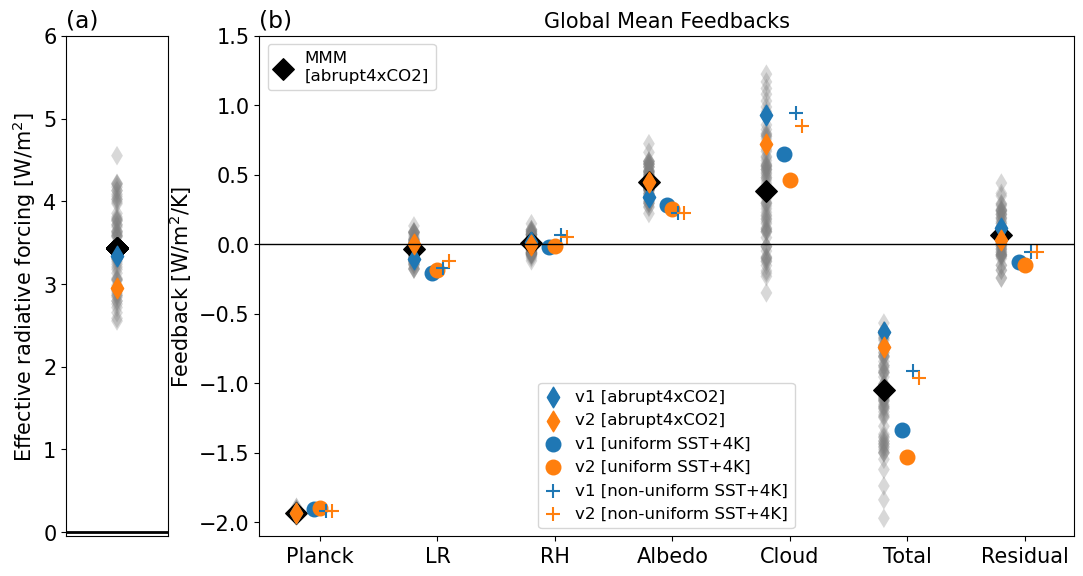

In [15]:
from matplotlib.gridspec import GridSpec

# ================ start plotting ==========================
# fig = plt.figure(figsize=(16,9))
fig = plt.figure(figsize=(13,6.5))

gs = GridSpec(1, 2, width_ratios=[1, 8])
ax = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[0])

s1 = 110
s2 = 100 
# colors = PDF.get_color('tab10',len(cases_here))
colors = ['tab:blue','tab:orange','tab:blue','tab:orange','tab:blue','tab:orange'] 
a1 = 1
fh = 15
fh1 = 13

# ============= plot ERF ===========================
for icol,column in enumerate(df_ERF_others.columns):
    ax2.scatter(1,df_ERF_others.loc['ERF',column].tolist()/2,s=s2,edgecolor='none',facecolor='grey',alpha=0.3,marker='d')
    
    # ensemble mean
    ax2.scatter(1, df_ERF_others.loc['ERF',:].mean()/2,s=s2+20,edgecolor='black',facecolor='black',marker='D')

#====== E3SM only 
for icol,column in enumerate(df_ERF_all.columns):
    ax2.scatter(1,df_ERF_all.loc['ERF',column].tolist()/2,s=s1,alpha=a1,label='_nolegend_',color=colors[icol],marker='d')

ax2.set_ylabel('Effective radiative forcing [W/m$^2$]',fontsize=fh)
ax2.axes.xaxis.set_visible(False)
ax2.set_ylim((-0.05,6))
ax2.axhline(y=0,ls='-',color='black',lw=2)
ax2.set_title('(a)',loc='left')

ax.set_title('(b)',loc='left')
         
# ============= plot feedbacks =====================

for idx,index in enumerate(indexA):
    # =========== other CMIP models
    if Add_otherCMIPs:
        for icol,column in enumerate(df_others_plot.columns):
            
            ax.scatter(x[idx]-0.2, df_others_plot.loc[index,column].tolist(),s=s2,edgecolor='none',facecolor='grey',alpha=0.3,marker='d')

        # ensemble mean
        L2 = ax.scatter(x[idx]-0.2, df_others_plot.loc[index,:].mean(),s=s2+20,edgecolor='black',facecolor='black',marker='D')

    # =========== E3SM only 
    for icol,column in enumerate(df_plot.columns):
        if column == 'v1_coupled' or column == 'v2_coupled':
            label = column.split('_')[0]+" [abrupt4xCO2]"
            if 'v2.NARRM.coupled' in df_plot.columns and column == 'v2_coupled':
                label = 'v2.LR'
            L1 = ax.scatter(x[idx]-0.2,df_plot.loc[index,column].tolist(),s=s1,alpha=a1,label=label,color=colors[icol],marker='d')
        elif column == 'v1_amip4K':
            ax.scatter(x[idx],df_plot.loc[index,column].tolist(),s=s1,alpha=a1,label=column,color=colors[icol],marker='x')
        elif column == 'v1_future4K':
            ax.scatter(x[idx],df_plot.loc[index,column].tolist(),s=s1,alpha=a1,label=column,color=colors[icol],marker='x')
        elif 'SST' in column:
            label = column.split('.')[0]+' [non-uniform SST+4K]'
            ax.scatter(x[idx]+icol/20.-len(df_plot.columns)/2.*1/20.,df_plot.loc[index,column].tolist(),s=s1,alpha=a1,label=label,
                       color=colors[icol],marker='+')
        else:
            if 'gwenergy' in column:
                label = 'All'
            elif column == 'v2.NARRM.coupled':
                label = 'v2.NARRM'
            elif 'SST' in column:
                label = column
            else:
                label = column.split('.')[-1]

            if column == 'v1' or column == 'v2': 
                label = column +" [uniform SST+4K]" 
                
            ax.scatter(x[idx]+icol/20.-len(df_plot.columns)/2.*1/20.,df_plot.loc[index,column].tolist(),s=s1,alpha=a1,label=label,
                       color=colors[icol])


    ax.tick_params(labelsize=fh)
    ax.set_ylabel('Feedback [W/m$^2$/K]',fontsize=fh)
    if idx == 0:
        if Add_otherCMIPs:
            if do_amip_cmip:
                label = 'amip4K'
            else:
                label = 'MMM\n[abrupt4xCO2]'

            legend1 = ax.legend([L2],[label],fontsize=12,loc='upper left')
            # ax.legend(fontsize=12,loc='upper right')
            ax.legend(fontsize=12,loc='lower center')
            ax.add_artist(legend1) 
        else:
            ax.legend(fontsize=12)

#ax.grid(which='major', linestyle=':', linewidth='1.0', color='grey')
ax.axhline(y=0,ls='-',color='black',lw=1)
degrees = 0

ax.set_xticks(x,xticks,rotation=degrees)
ax.set_title('Global Mean Feedbacks',fontsize=fh)

# # Add reference line between Cloud and Cloud_sw
# ax.axvline(x=5.5,ls='--',color='grey')
# # between Cloud_lw and Total 
# ax.axvline(x=7.5,ls='--',color='grey')
# # between Total and Residual
# ax.axvline(x=8.5,ls='--',color='grey')
# # between Residual and Planck_fxRH
# ax.axvline(x=9.5,ls='--',color='grey')

# ax.set_ylim((-3.5,2.5))
ax.set_ylim((-2.1,1.5))

fig.savefig(figdir+'ScatterPlot-RadKernel-NetFeedback_'+cases_here[-1]+'_'+dd+'.png',bbox_inches='tight',dpi=300)
fig.savefig(figdir+'ScatterPlot-RadKernel-NetFeedback_'+cases_here[-1]+'_'+dd+'.pdf',bbox_inches='tight') 
# plt.close(fig)


# spatial map

## define function

In [16]:
def add_others():
    #==================== add gridlines =================================
        if add_gridline:
            gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                              linewidth=1, color='gray', alpha=0.8, linestyle='--')
            gl.ylocator = mticker.FixedLocator([-60,-45,-30,-20,-10,0,10,20,30,45,60])
            gl.top_labels = False

        #==================== add box patches =================================
        if add_box:
            a2 = 0.3
            for ax in [ax1,ax2,ax3]:
                ax.add_patch(mpatches.Rectangle(xy=[240, -30], width=40, height=20,
                                                    edgecolor='black',
                                                    linewidth=3,
                                                    facecolor='none',
                                                    alpha=1.0,
                                                    transform=ccrs.PlateCarree())
                                 )

                ax.add_patch(mpatches.Rectangle(xy=[330, -30], width=30, height=20,
                                                    edgecolor='black',
                                                    linewidth=3,
                                                    facecolor='none',
                                                    alpha=1.0,
                                                    transform=ccrs.PlateCarree())
                                 )

                ax.add_patch(mpatches.Rectangle(xy=[200, 10], width=30, height=20,
                                                    edgecolor='black',
                                                    linewidth=3,
                                                    facecolor='none',
                                                    alpha=1.0,
                                                    transform=ccrs.PlateCarree())
                                 )

        #==================== add x and y tick labels =================================
        if add_ticks:
            for ax in [ax1,ax2,ax3]:
                ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
                ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
                lon_formatter = LongitudeFormatter(zero_direction_label=True)
                lat_formatter = LatitudeFormatter()
                ax.xaxis.set_major_formatter(lon_formatter)
                ax.yaxis.set_major_formatter(lat_formatter)

        #==================== add markers at specific locations =================================
        if add_markers:
            for ax in [ax1,ax2,ax3]:
                lonp = [280.5, 270.5, 260.5, 250.5]
                latp = [-20.5, -19.5, -15.5, -11.5]
                #color = 'white'
                color = 'black'
                ax.scatter(lonp,latp,marker='x', color=color,transform=ccrs.PlateCarree())


## Figure 2 and Figure S2

In [ ]:
datadir = workdir+"diag_feedback_E3SM/data/"

add_box = False # add box
add_gridline = False # add grid lines
add_markers = False # add specific markers
add_ticks = False # add tick markers

for flag in [
    'v1v2',          # Figure 2
    # 'v1v2coupled',   # Figure S2    
]:  
    if flag == 'v1v2coupled':
        case1_out = 'v1_coupled'
        case2_out = 'v2_coupled'
    if flag == 'v1v2':
        case1_out = 'v1'
        case2_out = 'v2'

    Vars = ['netCRE_ano_grd_adj']
    
    ## ===============================================
    ## read data
    ## ===============================================
    
    dics = {} 
    dics_st = {} 

    for var in Vars: 
        if var in ['netCRE_ano_grd_adj','SWCRE_ano_grd_adj','LWCRE_ano_grd_adj']:
                varout = var.split('_')[0]
                f1 = xr.open_dataset(datadir+'lat-lon-gfdbk-CMIP6-'+case1_out+'.nc')
                f2 = xr.open_dataset(datadir+'lat-lon-gfdbk-CMIP6-'+case2_out+'.nc')

                levels = np.arange(-3,3.2,0.2)
                levels_d = levels

                if flag != 'v1v2coupled': 
                    f1_st = xr.open_dataset(datadir+'lat-lon-gfdbk-anom-CMIP6-'+case1_out+'.nc')
                    f2_st = xr.open_dataset(datadir+'lat-lon-gfdbk-anom-CMIP6-'+case2_out+'.nc')
                else: 
                    # The following two files are generated by /global/homes/q/qinyi/tmp_scripts/cal_RadKern_regime_stderr.py on NERSC 
                    f1_st = xr.open_dataset(datadir+'test-rad_perK_latlon_abrupt-4xCO2_E3SM-1-0_r1i1p1f1_1yr-150yr.nc')
                    f2_st = xr.open_dataset(datadir+'test-rad_perK_latlon_abrupt-4xCO2_E3SM-2-0_r1i1p1f1_1yr-150yr.nc')


        if var in ['HI680_SWcld_tot','LO680_SWcld_tot','ALL_SWcld_tot']:
            varout = var
            f1 = xr.open_dataset(datadir+'global_cloud_feedback_'+case1_out+'.nc')
            f2 = xr.open_dataset(datadir+'global_cloud_feedback_'+case2_out+'.nc')

            levels = np.arange(-3,3.2,0.2)
            levels_d = levels 

        if var in ['EIS_ano_clim','EIS_pi_clim']:
            varout = var 
            f1 = xr.open_dataset(datadir+'global_EIS_'+case1_out+'.nc')
            f2 = xr.open_dataset(datadir+'global_EIS_'+case2_out+'.nc')

            if 'ano' in var:
                levels = np.arange(-0.5,0.6,0.1)
                levels_d = np.arange(-0.2,0.24,0.04)
            else:
                levels = np.arange(-2,12,2)
                levels_d = np.arange(-1,1.2,0.2)


        data = f1[var]
        data2 = f2[var]

        if flag != 'v1v2coupled':
            data_st = f1_st[var]
            data2_st = f2_st[var] 
        else: 
            data_st = f1_st['netCRE_adj_ano_fbk_stderr']
            data2_st = f2_st['netCRE_adj_ano_fbk_stderr']

        print('data_st.shape=',data_st.shape, 'data2_st.shape=',data2_st.shape)

        dics[var] = [data,data2,data2-data]
        dics_st[var] = [data_st, data2_st] 


    lons = data.lon[:]
    lats = data.lat[:]

    print(dics.keys())
    print(dics_st.keys())

    ## ===============================================
    ## plotting map 
    ## ===============================================
 
    fig = plt.figure(figsize=(12,6))
    nrow = 2
    ncol = 4

    gs = GridSpec(nrow,ncol, figure=fig)

    cmap = 'RdBu_r'

    ii = 0 
    for var in dics.keys():

        varout = var.split('_')[0] 

        if 'coupled' in case1_out:
            cases_out = [case1_out.split('_')[0]+' [abrupt4xCO2]', 
                         case2_out.split('_')[0]+' [abrupt4xCO2]', 
                         case2_out.split('_')[0]+' [abrupt4xCO2]'+' minus '+case1_out.split('_')[0]+' [abrupt4xCO2]']


        else:
            cases_out = [case1_out.split('.')[-1], case2_out.split('.')[-1], case2_out.split('.')[-1]+' minus '+case1_out.split('.')[-1]] 

        for ida,da in enumerate(dics[var]):

            # ax1 = fig.add_subplot(nrow,ncol,ii+1,projection=ccrs.PlateCarree(180))
            if ida == 0:
                axx = gs[0,0:2]
            elif ida == 1:
                axx = gs[0,2:]
            else: # difference map 
                if flag != 'v1v2coupled':
                    axx = gs[1,0:2] 
                else: 
                    axx = gs[1,1:3]

            ax1 = fig.add_subplot(axx,projection=ccrs.PlateCarree(180))

            im = ax1.contourf(lons,lats,da,transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,extend='both')

            # =============================================================
            # add significance in the difference map
            # =============================================================
            if ida == 2: 
                if flag != 'v1v2coupled': 
                    statres, pval = ttest_rel(dics_st[var][1],dics_st[var][0]) 
                else:
                    zz = da / np.sqrt(dics_st[var][1].interp(lat=da.lat,lon=da.lon)**2 + dics_st[var][0].interp(lat=da.lat,lon=da.lon)**2) 
                    
                    print('zz.shape=',zz.shape,'da.shape=',da.shape)
                    pval = norm.sf(abs(zz)) 

                spy1 = np.where(pval < 0.05, 1, 0)
                ax1.contourf(lons,lats,spy1, transform=ccrs.PlateCarree(),levels=[0.5,1.5],colors='none',hatches=['...','//'])  

            ax1.coastlines()
            avgdata = v1v2.area_averager(da).values 

            if 'coupled' in case1_out and (ii+1) in [3,6,9]:
                plt.title('('+chr(ord('`')+(ii+1))+') '+'('+chr(ord('`')+(ii))+') minus '+'('+chr(ord('`')+(ii-1))+')'+' ['+str(np.round(avgdata,2))+']')
            else:
                plt.title('('+chr(ord('`')+(ii+1))+') '+cases_out[ida]+' ['+str(np.round(avgdata,2))+']')

            # =============================================================
            ## Read frac_map and overlay to the contourf map
            # =============================================================
            if flag != 'v1v2coupled': 
                with xr.open_dataset(figdir+'saved_frac_map.nc') as f1:
                    frac_map = f1['frac_map']

                ax1.contour(lons,lats,frac_map,transform=ccrs.PlateCarree(),levels=[0.5],colors='black',linewidths=1.0,linestyles='dashed')

                for latspc in [-30,28,-60,60]:
                    ax1.axhline(y=latspc,ls='--',lw=1.0,color='grey')

                ax1.set_global()

            ii += 1

    # =============================================================
    # Add partitioned cloud regime map 
    # =============================================================
    if flag != 'v1v2coupled': 
        axx = gs[1,2:] 
        axf = fig.add_subplot(axx,projection=ccrs.PlateCarree(180))

        regimes = ['TropMarineLow','TropAscent','TropLand','MidLat','HiLat']
        colorsh = v1v2.get_color('tab10',len(regimes))
        frac_values = [21.3, 16.0, 12.7, 36.6, 13.4] 
        cmap = mpl.colors.LinearSegmentedColormap.from_list("", colorsh)

        lon2d,lat2d = np.meshgrid(lons,lats)
        imf = axf.pcolormesh(lon2d,lat2d,frac_map,transform=ccrs.PlateCarree(),cmap=cmap)
        axf.set_global()
        axf.coastlines()
        axf.set_title('(d) Partitioned cloud regimes') 

        patches = []
        for ireg,reg in enumerate(regimes): 
            patch = mpatches.Patch(color=colorsh[ireg], label=reg+' ['+str(frac_values[ireg])+'%]')
            patches.append(patch)
        axf.legend(handles=patches,ncol=2,bbox_to_anchor=(0.3,-0.1,0.8,0.1),
                   handleheight=0.3, handlelength=0.7,labelspacing=0.3,columnspacing=1.0)

    # =============================================================
    # add common colorbar
    # =============================================================
    if len(Vars) == 3:
        pos2 = [0.92, 0.15, 0.015, 0.2] # [x0,y0,width,height]
    else:
        if flag != 'v1v2coupled': 
            pos2 = [0.15,0.05,0.33,0.03] 
        else: 
            pos2 = [0.7, 0.11, 0.015, 0.35]


    fh = 13

    cbar_ax = fig.add_axes(pos2)
    if flag != 'v1v2coupled': 
        orientation = 'horizontal'
    else:
        orientation = 'vertical' 
    
    cb = fig.colorbar(im,ax=ax1, orientation=orientation, cax=cbar_ax)

    cb.set_label('W/$^2$/K',fontsize=fh)
    cb.ax.tick_params(labelsize=fh)
    tick_locator = ticker.MaxNLocator(nbins=7)
    cb.locator = tick_locator
    cb.update_ticks()

    fig.subplots_adjust(wspace=0.1)
    
    fig.savefig(figdir+'LatLon_fdbkpatt_'+flag+'_'+Vars[-1]+'_'+dd+'.png',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+'LatLon_fdbkpatt_'+flag+'_'+Vars[-1]+'_'+dd+'.pdf',bbox_inches='tight')
